# Initialization using shapefiles and rasters

The initial conditions of the simulation are dictated by demographics (e.g., population, age distribution, etc.). The laser-measles package provides a number of tools to help you generate demographics for your simulation. In this tutorial, we'll download and process a shapefile of Ethiopia at administrative level 1 boundaries to estimate intitial populations per patch. We will also show how we can sub-divide each boundary shape into roughly equal-area patches.

## Setup and plot the shapefile

laser-measles provides some functionality for downloading and plotting GADM shapefiles. Below we will download the data, print it as a dataframe, and then plot it. Note that we have constructed a `DOTNAME` attribute has the format `COUNTRY:REGION`. The data is located in the local directory.

Shapefile is now at /home/krosenfeld/projects/laser-measles/docs/tutorials/ETH/gadm41_ETH_1.shp
shape: (2, 13)
┌─────────┬───────┬──────────┬─────────────┬───┬────────┬───────┬──────────────────────┬───────────┐
│ GID_1   ┆ GID_0 ┆ COUNTRY  ┆ NAME_1      ┆ … ┆ HASC_1 ┆ ISO_1 ┆ DOTNAME              ┆ shape     │
│ ---     ┆ ---   ┆ ---      ┆ ---         ┆   ┆ ---    ┆ ---   ┆ ---                  ┆ ---       │
│ str     ┆ str   ┆ str      ┆ str         ┆   ┆ str    ┆ str   ┆ str                  ┆ object    │
╞═════════╪═══════╪══════════╪═════════════╪═══╪════════╪═══════╪══════════════════════╪═══════════╡
│ ETH.1_1 ┆ ETH   ┆ Ethiopia ┆ Addis Abeba ┆ … ┆ ET.AA  ┆ NA    ┆ ethiopia:addis abeba ┆ Shape #0: │
│         ┆       ┆          ┆             ┆   ┆        ┆       ┆                      ┆ POLYGON   │
│ ETH.2_1 ┆ ETH   ┆ Ethiopia ┆ Afar        ┆ … ┆ ET.AF  ┆ ET-AF ┆ ethiopia:afar        ┆ Shape #1: │
│         ┆       ┆          ┆             ┆   ┆        ┆       ┆                

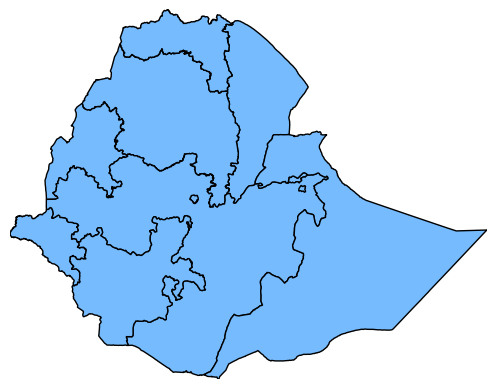

In [1]:
from pathlib import Path
from laser_measles import GADMShapefile, get_shapefile_dataframe, plot_shapefile_dataframe

shapefile = Path("ETH/gadm41_ETH_1.shp")

if not shapefile.exists():
    shp = GADMShapefile.download("ETH", admin_level=1 )
    print("Shapefile is now at", shp.shapefile)
else:
    print("Shapefile already exists")
    shp = GADMShapefile(shapefile=shapefile, admin_level=1)

df = get_shapefile_dataframe(shp.shapefile)
print(df.head(n=2))

plot_shapefile_dataframe(df, plot_kwargs={'facecolor': 'xkcd:sky blue'});

## Population calculation

For the simulation we will want to know the initial number of people in each region. First we'll download our population file (~5.6MB) from worldpop using standard libraries:

In [2]:
import requests

url = "https://data.worldpop.org/GIS/Population/Global_2000_2020_1km_UNadj/2010/ETH/eth_ppp_2010_1km_Aggregated_UNadj.tif"
output_path = Path("ETH/eth_ppp_2010_1km_Aggregated_UNadj.tif")

if not output_path.exists():
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(output_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print("Download complete.")
    else:
        print(f"Failed to download. Status code: {response.status_code}")

Download complete.


We use the `RasterPatchGenerator` to sum the population in each of the shapes. This is saved into a dataframe that we can use to initialize a simulation.

In [3]:
from laser_measles import RasterPatchConfig, RasterPatchGenerator
import sciris as sc
# Setup demographics generator
config = RasterPatchConfig(
    id="ETH_ADM1",
    region="ETH",
    shapefile=shp.shapefile,
    population_raster=output_path,
)
generator = RasterPatchGenerator(config)
with sc.Timer() as t:
    # Generate the demographics (in this case the population)
    generator.generate_demographics()
    print(f"Total population: {generator.population['pop'].sum()/1e6:.2f} million") # Should be ~90.5M
generator.population.head(n=2)

on 0: Loading data...


on 0: Clipping:
on 0: 1 of 11 (9%) ethiopia:addis abeba (np.float64(38.785538550534746), np.float64(8.98048294246869)) {'lat': np.float64(8.98048294246869), 'lon': np.float64(38.785538550534746), 'pop': 3189938}
on 0: 2 of 11 (18%) ethiopia:afar (np.float64(40.767449344797555), np.float64(12.037909353819343)) {'lat': np.float64(12.037909353819343), 'lon': np.float64(40.767449344797555), 'pop': 1619009}
on 0: 3 of 11 (27%) ethiopia:amhara (np.float64(38.04732030224195), np.float64(11.562494255356375)) {'lat': np.float64(11.562494255356375), 'lon': np.float64(38.04732030224195), 'pop': 20078508}
on 0: 4 of 11 (36%) ethiopia:benshangul-gumaz (np.float64(35.44237778797806), np.float64(10.50800671019417)) {'lat': np.float64(10.50800671019417), 'lon': np.float64(35.44237778797806), 'pop': 942015}
on 0: 5 of 11 (45%) ethiopia:dire dawa (np.float64(42.00302663044891), np.float64(9.60626902481112)) {'lat': np.float64(9.60626902481112), 'lon': np.float64(42.00302663044891), 'pop': 403830}
on 0: 

dotname,lat,lon,pop
str,f64,f64,i64
"""ethiopia:addis abeba""",8.980483,38.785539,3189938
"""ethiopia:afar""",12.037909,40.767449,1619009


laser-measles demographics uses caching to save results. Now we will run the calculation again with a new instance of the `RasterPatchGenerator`.

In [4]:
new_generator = RasterPatchGenerator(config)
with sc.Timer() as t:
    # # Generate the demographics (in this case the population)
    new_generator.generate_demographics()
    print(f"Total population: {new_generator.population['pop'].sum()/1e6:.2f} million") # Should be ~90.5M

Total population: 87.49 million
Elapsed time: 17.1 ms


You can access the cache directory using the associated module

In [5]:
from laser_measles.demographics import cache
print(f"Cache directory: {cache.get_cache_dir()}")

Cache directory: /home/krosenfeld/.cache/laser_measles


## Sub-divide the regions

Now we will generate roughtly equal area patches of 700 km using the original `shp` shapefile. Now each shape has a unique identifier with the form `COUNTRY:REGION:ID`. We will also time how long this takes.

Subdividing shapefile gadm41_ETH_1 |████████████████████████████████████████| 0 in 9.2s (0.00/s) 
Shapefile is now at /home/krosenfeld/projects/laser-measles/docs/tutorials/ETH/gadm41_ETH_1_700km.shp


DOTNAME,GID_1,GID_0,COUNTRY,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,ISO_1,shape
str,str,str,str,str,str,str,str,str,str,str,str,object
"""ethiopia:addis abeba:A0000""","""ETH.1_1""","""ETH""","""Ethiopia""","""Addis Abeba""","""Āddīs Ābaba|Addis Ababa|Adis-A…","""NA""","""Astedader""","""City""","""14""","""ET.AA""","""NA""",Shape #0: POLYGON
"""ethiopia:afar:A0000""","""ETH.2_1""","""ETH""","""Ethiopia""","""Afar""","""NA""","""NA""","""Kilil""","""State""","""02""","""ET.AF""","""ET-AF""",Shape #1: POLYGON


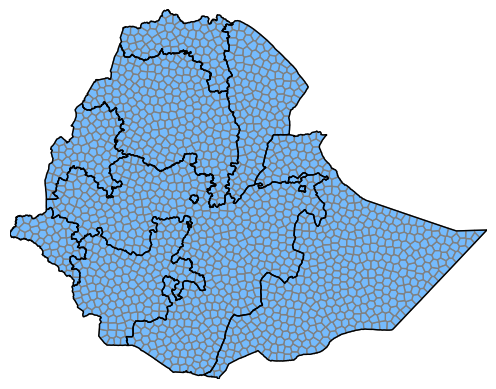

In [6]:
patch_size = 700 # km
new_shapefile = Path(f"ETH/gadm41_ETH_1_{patch_size}km.shp")

new_shp = GADMShapefile(shapefile=shp.shapefile, admin_level=1)
new_shp.shape_subdivide(patch_size_km=patch_size)
print("Shapefile is now at", new_shp.shapefile)

new_df = get_shapefile_dataframe(new_shp.shapefile)
display(new_df.head(n=2))

import matplotlib.pyplot as plt
plt.figure()
ax = plt.gca()
plot_shapefile_dataframe(new_df, plot_kwargs={'facecolor': 'xkcd:sky blue', 'edgecolor':'gray'}, ax=ax)
plot_shapefile_dataframe(df, plot_kwargs={'fill': False}, ax=ax);